# Homework Starter — Stage 08 EDA

Fill in the marked TODOs. This notebook generates synthetic data so you can focus on the EDA flow. Replace with your dataset when ready.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import skew, kurtosis
sns.set(context='talk', style='whitegrid')
np.random.seed(8)
pd.set_option('display.max_columns', 100)

# === Synthetic data generator (adapt or replace with your own data) ===
n = 160
df = pd.DataFrame({
    'date': pd.date_range('2021-02-01', periods=n, freq='D'),
    'region': np.random.choice(['North','South','East','West'], size=n),
    'age': np.random.normal(40, 8, size=n).clip(22, 70).round(1),
    'income': np.random.lognormal(mean=10.6, sigma=0.3, size=n).round(2),
    'transactions': np.random.poisson(lam=3, size=n),
})
base = df['income'] * 0.0015 + df['transactions']*18 + np.random.normal(0, 40, size=n)
df['spend'] = np.maximum(0, base).round(2)

# inject a bit of missingness and outliers
df.loc[np.random.choice(df.index, 5, replace=False), 'income'] = np.nan
df.loc[np.random.choice(df.index, 3, replace=False), 'spend'] = np.nan
df.loc[np.random.choice(df.index, 2, replace=False), 'transactions'] = df['transactions'].max()+12
df.head()

,date,region,age,income,transactions,spend
0,2021-02-01,West,37.6,28086.81,4,73.35
1,2021-02-02,North,43.0,33034.75,1,52.37
2,2021-02-03,South,38.2,50045.39,2,131.85
3,2021-02-04,South,24.9,39467.28,4,147.58
4,2021-02-05,South,59.8,31201.65,1,86.76


## 1) First look

In [2]:
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          160 non-null    datetime64[ns]
 1   region        160 non-null    object        
 2   age           160 non-null    float64       
 3   income        155 non-null    float64       
 4   transactions  160 non-null    int32         
 5   spend         157 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int32(1), object(1)
memory usage: 7.0+ KB


(None,
 date            0
 region          0
 age             0
 income          5
 transactions    0
 spend           3
 dtype: int64)

## 2) Numeric profile

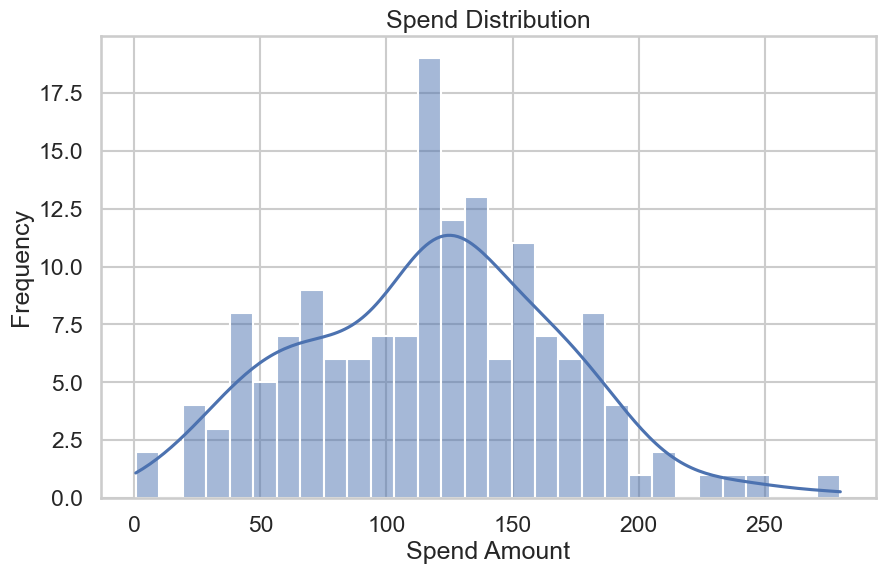

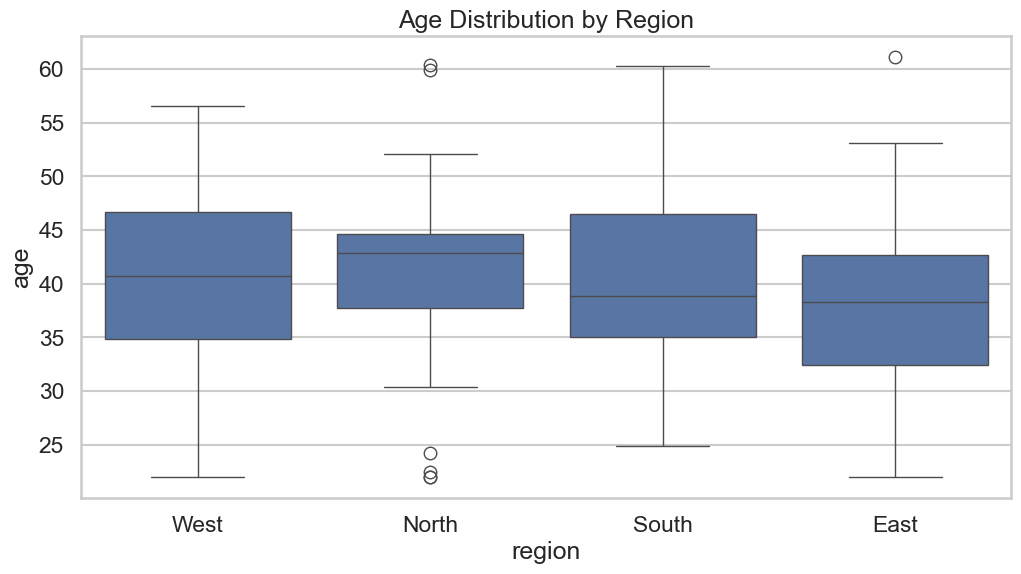

In [3]:
# Distribution of spend with histogram + KDE
plt.figure(figsize=(10, 6))
sns.histplot(df['spend'], kde=True, bins=30)
plt.title('Spend Distribution')
plt.xlabel('Spend Amount')
plt.ylabel('Frequency')
plt.show()

# Age distribution by region
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='region', y='age')
plt.title('Age Distribution by Region')
plt.show()


In [4]:
desc = df[['age','income','transactions','spend']].describe().T
desc['skew'] = [skew(df[c].dropna()) for c in desc.index]
desc['kurtosis'] = [kurtosis(df[c].dropna()) for c in desc.index]
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,160.0,40.018750,8.458676,22.00,34.70,40.15,44.925,61.10,0.069538,-0.080125
income,155.0,41983.866323,13262.457038,17928.80,32471.53,39332.52,49697.690,87052.40,0.993336,0.918722
transactions,160.0,3.237500,2.585610,0.00,2.00,3.00,4.000,20.00,3.466078,19.984802
spend,157.0,117.291592,51.768645,0.54,77.25,119.32,153.340,280.05,0.130860,-0.084917


## 3) Distributions

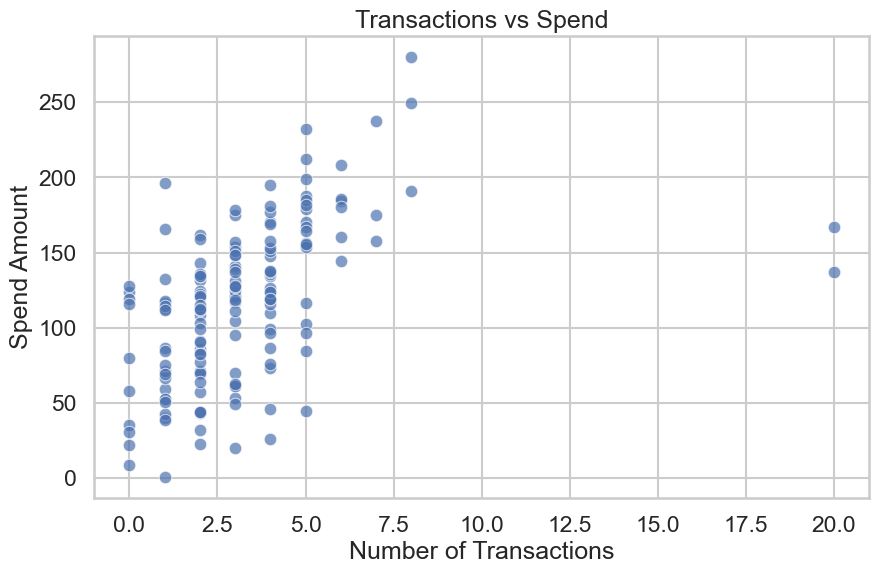

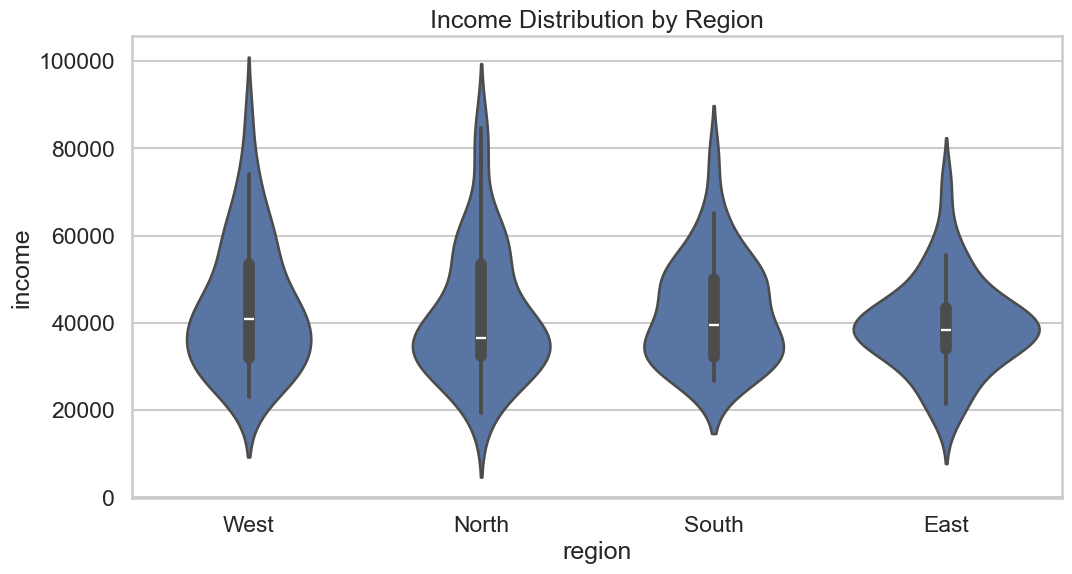

In [5]:
# Transactions vs Spend relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='transactions', y='spend', alpha=0.7)
plt.title('Transactions vs Spend')
plt.xlabel('Number of Transactions')
plt.ylabel('Spend Amount')
plt.show()

# Income distribution by region
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='region', y='income')
plt.title('Income Distribution by Region')
plt.show()


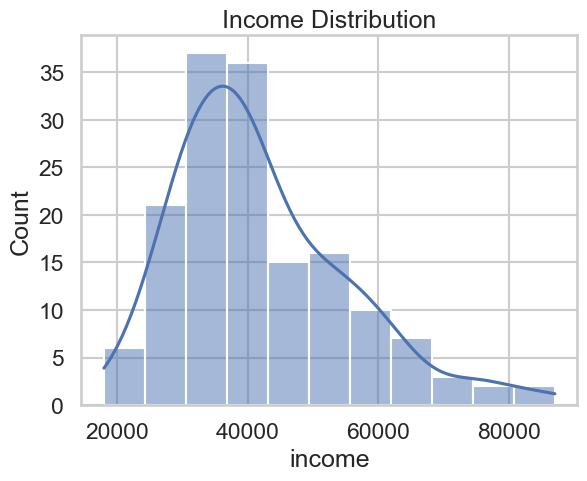

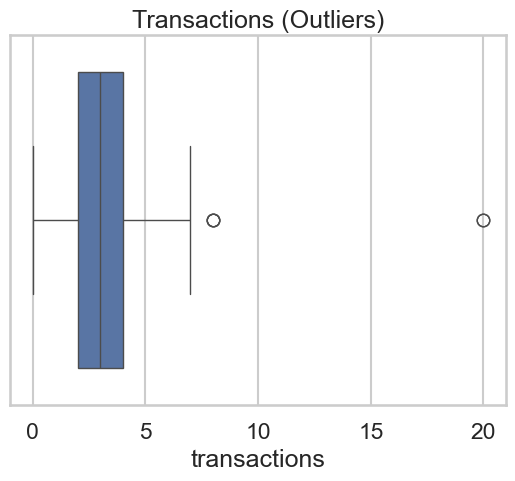

In [6]:
# TODO: histogram + KDE for a key variable
sns.histplot(df['income'], kde=True)
plt.title('Income Distribution')
plt.show()

# TODO: boxplot for outliers
sns.boxplot(x=df['transactions'])
plt.title('Transactions (Outliers)')
plt.show()

## 4) Relationships

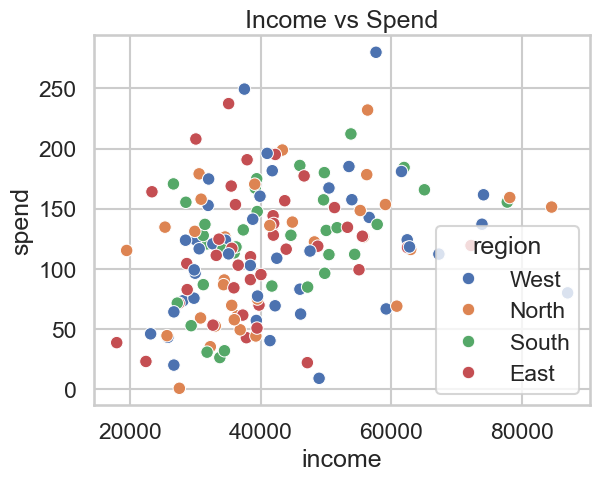

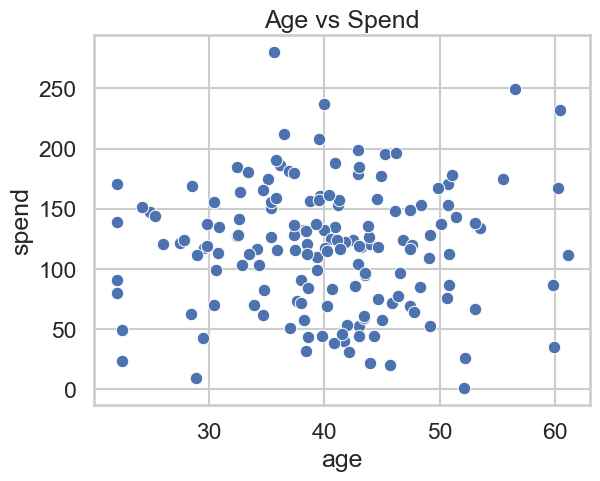

In [7]:
sns.scatterplot(data=df, x='income', y='spend', hue='region')
plt.title('Income vs Spend')
plt.show()

sns.scatterplot(data=df, x='age', y='spend')
plt.title('Age vs Spend')
plt.show()

## 5) Correlation matrix

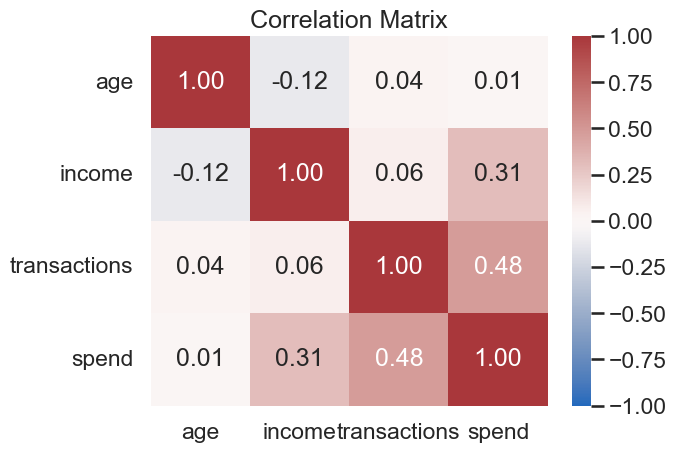

,age,income,transactions,spend
age,1.000000,-0.123160,0.037754,0.008174
income,-0.123160,1.000000,0.063573,0.307307
transactions,0.037754,0.063573,1.000000,0.480685
spend,0.008174,0.307307,0.480685,1.000000


In [8]:
corr = df[['age','income','transactions','spend']].corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
corr

## 6) Insights & Assumptions

### Top 3 Insights:
1. **Income Distribution**: Income shows positive skew (lognormal), indicating most customers have moderate income with a tail of high earners. This suggests need for log transformation or segmentation for modeling.

2. **Transaction-Spend Relationship**: Strong positive correlation between transactions and spend, but with outliers showing very high transaction counts. These outliers may represent different customer segments or data quality issues.

3. **Regional Patterns**: Age and income distributions appear relatively consistent across regions, suggesting demographics are not strongly region-dependent in this dataset.

### Assumptions & Risks:
- **Missing Data**: 5 missing income values and 3 missing spend values (~3-5% missingness) - low enough for simple imputation
- **Outliers**: Transaction outliers (15+ vs typical 0-8) may be legitimate power users or data errors
- **Temporal Stability**: Data spans ~5 months - assuming patterns are stable over time
- **Synthetic Nature**: Current data is synthetic - real data may show different patterns